# Determinação de um Raster matricial da densidade construtiva a partir do IPTU

In [1]:
import geopandas as gpd
import pandas as pd
import rasterio

## Carregando e pré-processando dados do IPTU

In [2]:
# Padrões de nomenclatura de usos

usos = {
    "apartamento em condomínio":"apartamento",
    "cortiço (habitação coletiva subnormal)":"cortiço",
    "escritório/consultório em condomínio (unidade autônoma)":"escritório ou consultório",
    "loja em edifício em condomínio (unidade autônoma)":"loja em edifício em condomínio",
    "residência coletiva, exclusive cortiço (mais de uma residência no lote)":"residência coletiva (mais de uma residência no lote), exclusive cortiço",
    "posto de serviço (combustíveis)":"posto de serviço",
    "estacionamento e garagem, não em condomínio":"garagem (exclusive em prédio em condomínio)",
    "garagem (unidade autônoma) de prédio de garagens":"garagem, em prédio de garagens",
    "garagem (unidade autônoma) em edifício em condomínio de escritórios, consultórios ou misto":"garagem em edifício de escritórios, consultórios ou misto",
    "garagem (unidade autônoma) em edifício em condomínio de uso exclusivamente residencial":"garagem em edifício de uso exclusivamente residencial",
    "outras edificações de uso coletivo, com utilização múltipla":"outras edificações do tipo (uso coletivo), com utilização múltipla",
    "outras edificações de uso comercial, com utilização múltipla":"outras edificações do tipo (uso comércio), com utilização múltipla",
    "outras edificações de uso de serviço, com utilização múltipla":"outras edificações do tipo (uso serviço), com utilização múltipla",
    "outras edificações de uso especial, com utilização múltipla":"outras edificações do tipo (uso especial), com utilização múltipla",
    "prédio com uso exclusivamente residencial, não em condomínio":"prédio de apartamento, não em condomínio, de uso exclusivamente residencial",
    "prédio com uso misto, predominância de uso não residencial, não em condomínio":"prédio de escritório, não em condomínio, de uso misto (apartamentos e escritórios e/ou consultórios) com ou sem loja (predominância comercial)",
    "prédio com uso misto, predominância de uso residencial, não em condomínio":"prédio de apartamento, não em condomínio, de uso misto (apartamentos e escritórios e/ou consultórios), com ou sem loja (predominância residencial)",
    "prédio de escritório ou consultório, com ou sem lojas, não em condomínio":"prédio de escritório ou consultório, não em condomínio, com ou sem lojas",
    "flat de uso comercial (semelhante a hotel)":"flat, não residencial",
    "flat residencial em condomínio":"flat, residencial"
}

In [3]:
df_iptu = pd.read_csv('IPTU/IPTU_2020.zip',\
             compression='zip',\
             encoding='iso-8859-9',\
             sep=';',\
             decimal=',',\
             error_bad_lines=False)

In [4]:
# Obter o SQ (Setor e Quadra)
df_iptu['setor'] = df_iptu['NUMERO DO CONTRIBUINTE'].str[0:3]
df_iptu['quadra'] = df_iptu['NUMERO DO CONTRIBUINTE'].str[3:6]

# Calculando chave 'SQ'
df_iptu['sq'] = \
df_iptu['setor'] + df_iptu['quadra']

# Normalizando o lote condominial
df_iptu.loc[df_iptu['NUMERO DO CONDOMINIO'].str[0:2] != '00', 'lote'] = '0000'
df_iptu.loc[df_iptu['NUMERO DO CONDOMINIO'].str[0:2] == '00', 'lote'] = \
df_iptu.loc[df_iptu['NUMERO DO CONDOMINIO'].str[0:2] == '00', 'NUMERO DO CONTRIBUINTE'].str[6:10]

# Individualizando a testada e pavimentos por lote (SQLC)
df_iptu['sqlc'] = df_iptu['setor'] + \
df_iptu['quadra'] + df_iptu['lote'] + \
df_iptu['NUMERO DO CONDOMINIO'].str[0:2]

df_iptu['AREA CONSTRUIDA'] = pd.to_numeric(df_iptu['AREA CONSTRUIDA'], errors ='coerce')
df_iptu['AREA OCUPADA'] = pd.to_numeric(df_iptu['AREA OCUPADA'], errors ='coerce')
df_iptu['AREA DO TERRENO'] = pd.to_numeric(df_iptu['AREA DO TERRENO'], errors ='coerce')
df_iptu['FRACAO IDEAL'] = pd.to_numeric(df_iptu['FRACAO IDEAL'], errors ='coerce')
df_iptu['QUANTIDADE DE PAVIMENTOS'] = pd.to_numeric(df_iptu['QUANTIDADE DE PAVIMENTOS'], errors ='coerce')
df_iptu['TESTADA PARA CALCULO'] = pd.to_numeric(df_iptu['TESTADA PARA CALCULO'], errors ='coerce')

# Adequando variáveis à fração ideal
df_iptu['area_terreno'] = df_iptu['FRACAO IDEAL'] * df_iptu['AREA DO TERRENO']
df_iptu['area_ocupada'] = df_iptu['FRACAO IDEAL'] * df_iptu['AREA OCUPADA']

# Adequar os usos ao padrão estabelecido
df_iptu.loc[df_iptu['TIPO DE USO DO IMOVEL']\
            .isin(usos),\
            'TIPO DE USO DO IMOVEL'] = \
df_iptu[df_iptu['TIPO DE USO DO IMOVEL']\
             .isin(usos)]['TIPO DE USO DO IMOVEL']\
.apply(lambda x: usos[x])

## Carregando e pré-processando quadras

In [5]:
# Carregando geometria das quadras fiscais
gdf_quadras = gpd.GeoDataFrame.from_file(f'zip://GIS/SIRGAS_SHP_quadraMDSF.zip!SIRGAS_SHP_quadraMDSF')

In [6]:
gdf_quadras['sq'] = gdf_quadras.qd_setor + gdf_quadras.qd_fiscal

In [7]:
gdf_quadras = gdf_quadras.loc[gdf_quadras.qd_tipo == 'F'][['sq', 'geometry']].dissolve(by='sq')

In [8]:
gdf_quadras.geometry = gdf_quadras.representative_point()

## Um pouco sobre testada

<AxesSubplot:>

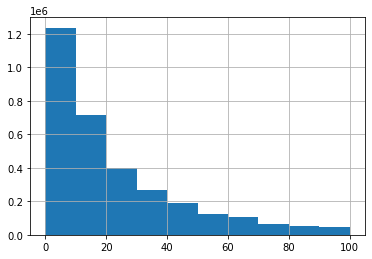

In [19]:
df_iptu.loc[df_iptu['TESTADA PARA CALCULO'] < 100, 'TESTADA PARA CALCULO'].hist()

<AxesSubplot:>

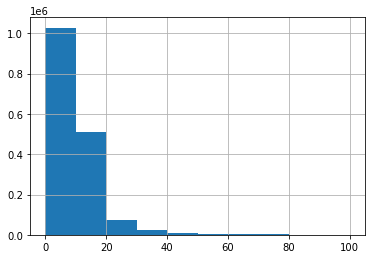

In [24]:
df_iptu.loc[df_iptu['TESTADA PARA CALCULO'] < 100, ['sqlc','TESTADA PARA CALCULO']].\
groupby('sqlc')['TESTADA PARA CALCULO'].max().hist()

In [33]:
len(df_iptu.loc[df_iptu['TESTADA PARA CALCULO'] <= 10, ['sqlc', 'TESTADA PARA CALCULO']].\
groupby('sqlc')['TESTADA PARA CALCULO'].max())

1304817

## Agregando e espacializando dado de densidade contruída

In [42]:
# Agregar por SQ e ANO DO EXERCICIO
iptu_agg = df_iptu[['sq', \
                    'AREA CONSTRUIDA',
                    'area_terreno',
                    'area_ocupada',
                    'QUANTIDADE DE PAVIMENTOS',
                    'TESTADA PARA CALCULO']]\
.groupby('sq')\
.agg({'AREA CONSTRUIDA': 'sum',
     'area_terreno': 'sum',
     'area_ocupada': 'sum',
     'QUANTIDADE DE PAVIMENTOS': 'median',
     'TESTADA PARA CALCULO': 'median'})\
.rename(columns = {'AREA CONSTRUIDA': 'area_construida',
                  'QUANTIDADE DE PAVIMENTOS': 'mediana_pavimentos',
                  'TESTADA PARA CALCULO':'mediana_testada'})

In [46]:
# Gerando GeoDataFrame
gdf_iptu_agg = gdf_quadras.merge(iptu_agg, on='sq', how='right')

## Construindo raster matricial de densidade construtiva

In [50]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import rasterio

In [194]:
resolucao_espacial = 30

In [195]:
limite_municipio = gpd.read_file('GIS/municipio-de-São-Paulo.gpkg')

/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [196]:
limite_municipio.bounds

,minx,miny,maxx,maxy
0,313389.670936,7.343743e+06,360618.197706,7.416156e+06


In [197]:
x_range = np.arange(limite_municipio.bounds.minx[0],
                    limite_municipio.bounds.maxx[0] + resolucao_espacial,
                    resolucao_espacial)

y_range = np.arange(limite_municipio.bounds.miny[0],
                    limite_municipio.bounds.maxy[0] + resolucao_espacial,
                    resolucao_espacial)

In [198]:
grid_x, grid_y = np.meshgrid(x_range, y_range)

In [199]:
gdf_iptu_agg = gdf_iptu_agg[gdf_iptu_agg.is_valid]

In [200]:
points = list(gdf_iptu_agg.geometry.apply(lambda p: (p.x, p.y)))

In [201]:
values = gdf_iptu_agg['area_construida'] / gdf_iptu_agg['area_terreno']

In [202]:
print(len(points), len(values))

45381 45381


In [203]:
# Interpolando no grid

grid_ca = griddata(points, values, (grid_x, grid_y), method='nearest')

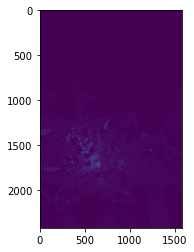

In [204]:
plt.imshow(grid_ca)

### Salvando em um arquivo raster

In [215]:
from rasterio.transform import Affine
from rasterio import mask
from rasterio.crs import CRS

In [206]:
transform = Affine.translation(grid_x[0][0] - resolucao_espacial / 2, 
                               grid_y[0][0] - resolucao_espacial / 2 ) \
                               * Affine.scale(resolucao_espacial, resolucao_espacial)
transform

Affine(30.0, 0.0, 313374.67093572277,
       0.0, 30.0, 7343727.818227606)

In [207]:
raster_crs = CRS.from_epsg(31983)

In [243]:
grid_ca = grid_ca.astype('float32')

In [244]:
raster_crs.data

{'init': 'epsg:31983'}

In [271]:
meta = {
    'driver':'GTiff',
    'height':grid_ca.shape[0],
    'width':grid_ca.shape[1],
    'count':1,
    'nodata':0.,
    'dtype':grid_ca.dtype,
    'crs':raster_crs,
    'transform':transform,
}

In [272]:
meta

{'driver': 'GTiff',
 'height': 2415,
 'width': 1576,
 'count': 1,
 'nodata': 0.0,
 'dtype': dtype('float32'),
 'crs': CRS.from_epsg(31983),
 'transform': Affine(30.0, 0.0, 313374.67093572277,
        0.0, 30.0, 7343727.818227606)}

In [273]:
with rasterio.open(f'resultados/IPTU-raster-CA-2020.TIF', "w", **meta) as dest:
    dest.write(grid_ca, 1)

In [274]:
result_dataset = rasterio.open(f'resultados/IPTU-raster-CA-2020.TIF')

out_image_crop, out_transform_crop = \
mask.mask(result_dataset, limite_municipio.geometry, crop=True, invert=False)

In [275]:
meta.update(transform = out_transform_crop)

In [276]:
with rasterio.open(f'resultados/IPTU-raster-CA-2020.TIF', "w", **meta) as dest:
    dest.write(out_image_crop)

## Gera raster densidade construtiva para cada ano

In [229]:
from pathlib import Path
import os

In [279]:
for path in Path('IPTU').rglob('*.zip'):
    print(path.name)
    
    # 1. Carregar dados do arquivo
    # OBS.: O IPTU de 2016 está separado por ',' e não por ';'
    if path.name == "IPTU_2016.zip":
        df_iptu = pd.read_csv(f'{path}',\
                     compression='zip',\
                     encoding='iso-8859-9',\
                     sep=',',\
                     decimal=',',\
                     error_bad_lines=False)
    else:
        df_iptu = pd.read_csv(f'{path}',\
                     compression='zip',\
                     encoding='iso-8859-9',\
                     sep=';',\
                     decimal=',',\
                     error_bad_lines=False)
        
    # Obter o SQ (Setor e Quadra)
    df_iptu['setor'] = df_iptu['NUMERO DO CONTRIBUINTE'].str[0:3]
    df_iptu['quadra'] = df_iptu['NUMERO DO CONTRIBUINTE'].str[3:6]

    # Calculando chave 'SQ'
    df_iptu['sq'] = \
    df_iptu['setor'] + df_iptu['quadra']

    # Normalizando o lote condominial
    df_iptu.loc[df_iptu['NUMERO DO CONDOMINIO'].str[0:2] != '00', 'lote'] = '0000'
    df_iptu.loc[df_iptu['NUMERO DO CONDOMINIO'].str[0:2] == '00', 'lote'] = \
    df_iptu.loc[df_iptu['NUMERO DO CONDOMINIO'].str[0:2] == '00', 'NUMERO DO CONTRIBUINTE'].str[6:10]

    # Individualizando a testada e pavimentos por lote (SQLC)
    df_iptu['sqlc'] = df_iptu['setor'] + \
    df_iptu['quadra'] + df_iptu['lote'] + \
    df_iptu['NUMERO DO CONDOMINIO'].str[0:2]

    df_iptu['AREA CONSTRUIDA'] = pd.to_numeric(df_iptu['AREA CONSTRUIDA'], errors ='coerce')
    df_iptu['AREA OCUPADA'] = pd.to_numeric(df_iptu['AREA OCUPADA'], errors ='coerce')
    df_iptu['AREA DO TERRENO'] = pd.to_numeric(df_iptu['AREA DO TERRENO'], errors ='coerce')
    df_iptu['FRACAO IDEAL'] = pd.to_numeric(df_iptu['FRACAO IDEAL'], errors ='coerce')
    df_iptu['QUANTIDADE DE PAVIMENTOS'] = pd.to_numeric(df_iptu['QUANTIDADE DE PAVIMENTOS'], errors ='coerce')
    df_iptu['TESTADA PARA CALCULO'] = pd.to_numeric(df_iptu['TESTADA PARA CALCULO'], errors ='coerce')

    # Adequando variáveis à fração ideal
    df_iptu['area_terreno'] = df_iptu['FRACAO IDEAL'] * df_iptu['AREA DO TERRENO']
    df_iptu['area_ocupada'] = df_iptu['FRACAO IDEAL'] * df_iptu['AREA OCUPADA']

    # Adequar os usos ao padrão estabelecido
    df_iptu.loc[df_iptu['TIPO DE USO DO IMOVEL']\
                .isin(usos),\
                'TIPO DE USO DO IMOVEL'] = \
    df_iptu[df_iptu['TIPO DE USO DO IMOVEL']\
                 .isin(usos)]['TIPO DE USO DO IMOVEL']\
    .apply(lambda x: usos[x])

    # Agregar por SQ e ANO DO EXERCICIO
    iptu_agg = df_iptu[['sq', \
                        'AREA CONSTRUIDA',
                        'area_terreno',
                        'area_ocupada',
                        'QUANTIDADE DE PAVIMENTOS',
                        'TESTADA PARA CALCULO']]\
    .groupby('sq')\
    .agg({'AREA CONSTRUIDA': 'sum',
         'area_terreno': 'sum',
         'area_ocupada': 'sum',
         'QUANTIDADE DE PAVIMENTOS': 'median',
         'TESTADA PARA CALCULO': 'median'})\
    .rename(columns = {'AREA CONSTRUIDA': 'area_construida',
                      'QUANTIDADE DE PAVIMENTOS': 'mediana_pavimentos',
                      'TESTADA PARA CALCULO':'mediana_testada'})
    
    # Gerando GeoDataFrame
    gdf_iptu_agg = gdf_quadras.merge(iptu_agg, on='sq', how='right')
    
    gdf_iptu_agg = gdf_iptu_agg[gdf_iptu_agg.is_valid]
    
    points = list(gdf_iptu_agg.geometry.apply(lambda p: (p.x, p.y)))
    
    values = gdf_iptu_agg['area_construida'] / gdf_iptu_agg['area_terreno']
    
    grid_ca = griddata(points, values, (grid_x, grid_y), method='nearest')
    grid_ca = grid_ca.astype('float32')
    
    with rasterio.open(f'resultados/densidade_construtiva/{path.name[:-4]}-raster-densidade-construtiva.TIF', "w", **meta) as dest:
        dest.write(grid_ca, 1)
        
    result_dataset = rasterio.open(f'resultados/densidade_construtiva/{path.name[:-4]}-raster-densidade-construtiva.TIF')

    out_image_crop, out_transform_crop = \
    mask.mask(result_dataset, limite_municipio.geometry, crop=True, invert=False)

    with rasterio.open(f'resultados/densidade_construtiva/{path.name[:-4]}-raster-densidade-construtiva.TIF', "w", **meta) as dest:
        dest.write(out_image_crop)

IPTU_2010.zip


b'Skipping line 2445507: expected 35 fields, saw 43\n'
/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


IPTU_1996.zip


/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


IPTU_2007.zip


b'Skipping line 2417712: expected 35 fields, saw 43\n'


IPTU_2013.zip


b'Skipping line 2560170: expected 35 fields, saw 43\n'
/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,19,20,21,22,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


IPTU_2004.zip


b'Skipping line 2325266: expected 35 fields, saw 43\n'


IPTU_2005.zip


b'Skipping line 2355090: expected 35 fields, saw 43\n'


IPTU_1995.zip


/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


IPTU_1998.zip


b'Skipping line 2096075: expected 35 fields, saw 43\n'


IPTU_2018.zip
IPTU_2001.zip


b'Skipping line 2211865: expected 35 fields, saw 43\n'


IPTU_2017.zip
IPTU_2015.zip


b'Skipping line 2651001: expected 35 fields, saw 43\n'
/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,19,20,21,22,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


IPTU_2006.zip


b'Skipping line 2381472: expected 35 fields, saw 43\n'


IPTU_2009.zip


b'Skipping line 2471701: expected 35 fields, saw 43\n'


IPTU_2014.zip


b'Skipping line 2606431: expected 35 fields, saw 43\n'
/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,19,20,21,22,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


IPTU_2011.zip


b'Skipping line 2484471: expected 35 fields, saw 43\n'
/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


IPTU_2000.zip


b'Skipping line 2156584: expected 35 fields, saw 43\n'


IPTU_2019.zip
IPTU_1997.zip


/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


IPTU_2016.zip
IPTU_2002.zip


b'Skipping line 2247445: expected 35 fields, saw 43\n'


IPTU_1999.zip


b'Skipping line 2121196: expected 35 fields, saw 43\n'


IPTU_2020.zip
IPTU_2008.zip


b'Skipping line 2440049: expected 35 fields, saw 43\n'


IPTU_2003.zip


b'Skipping line 2288886: expected 35 fields, saw 43\n'


IPTU_2012.zip


b'Skipping line 2526350: expected 35 fields, saw 43\n'
/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
